In [0]:
%load_ext autoreload
%autoreload 2
# Enables autoreload; learn more at https://docs.databricks.com/en/files/workspace-modules.html#autoreload-for-python-modules
# To disable autoreload; run %autoreload 0

# Imports

In [0]:
%pip install --upgrade joblib visions scikit-learn ydata-profiling
dbutils.library.restartPython()

Note: you may need to restart the kernel using %restart_python or dbutils.library.restartPython() to use updated packages.


In [0]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import col
from pyspark.sql import functions as F
from pyspark.sql import types as T
from pyspark.sql import Row

import os
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from pandas_profiling import ProfileReport
from difflib import get_close_matches
from datetime import datetime

from logger import log_message

#Functions

# Load Data

In [0]:
base_path = "file:/Workspace/Users/masa.cirkovic@abo.fi/"
golden_path = base_path + "medallion/gold/golden_data/"

In [0]:
# Load Golden Layer data
golden_df = spark.read.format("delta").load(golden_path)
golden_pandas_df = golden_df.toPandas()

# Profiling

In [0]:
base_path = "/Workspace/Users/masa.cirkovic@abo.fi/"
profile_path = base_path + "profile/"

In [0]:
profile = ProfileReport(golden_pandas_df, title="Golden Layer Data Profiling Report", explorative=True)
profiling_report_path = profile_path + "golden_layer_profiling_report.html"

os.makedirs(profile_path, exist_ok=True)

try:
    # Generate a profiling report for Golden Layer
    profile.to_file(profiling_report_path)
    log_message("info", "profiling_and_visualizations", "saving profiling report", "Profiling report for golden layer successfully saved")
except Exception as e:
    log_message("error", "profiling_and_visualizations", "saving profiling report", str(e))

print("Golden Layer profiling report successfully generated.")

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]


100%|██████████| 18/18 [00:02<00:00,  8.25it/s]
/local_disk0/.ephemeral_nfs/envs/pythonEnv-81688afa-460f-4d82-931c-4c3e2eabccc9/lib/python3.12/site-packages/ydata_profiling/model/pandas/discretize_pandas.py:52: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[6 1 2 ... 2 2 3]' has dtype incompatible with int32, please explicitly cast to a compatible dtype first.
  discretized_df.loc[:, column] = self._discretize_column(
/local_disk0/.ephemeral_nfs/envs/pythonEnv-81688afa-460f-4d82-931c-4c3e2eabccc9/lib/python3.12/site-packages/ydata_profiling/model/pandas/discretize_pandas.py:52: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[7 2 2 ... 1 7 0]' has dtype incompatible with int32, please explicitly cast to a compatible dtype first.
  discretized_df.loc[:, column] = self._discretize_column(
/local_disk0/.ephemeral_nfs/envs/pythonEnv-81688afa-460f-4d

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

Export report to file:   0%|          | 0/1 [00:00<?, ?it/s]

Golden Layer profiling report successfully generated.


## Insights & Visualizations

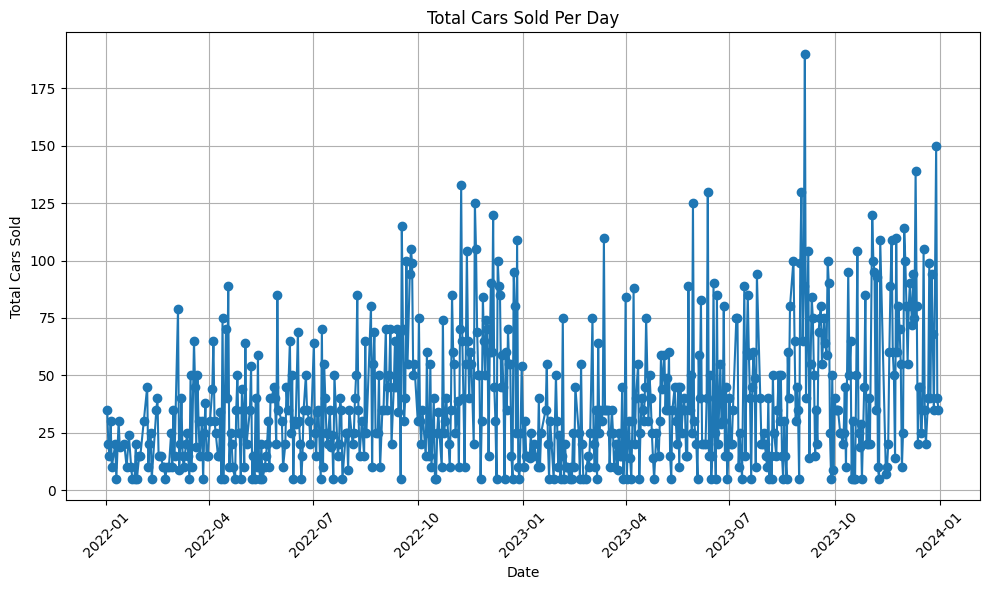

In [0]:
# Aggregate total cars sold per day
cars_sold_per_day = golden_pandas_df.groupby("date").size().reset_index(name="count")

# Sort values for better visualization
cars_sold_per_day = cars_sold_per_day.sort_values("date")

# Plotting
plt.figure(figsize=(10, 6))
plt.plot(cars_sold_per_day["date"], cars_sold_per_day["count"], marker='o', linestyle='-')
plt.title("Total Cars Sold Per Day")
plt.xlabel("Date")
plt.ylabel("Total Cars Sold")
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

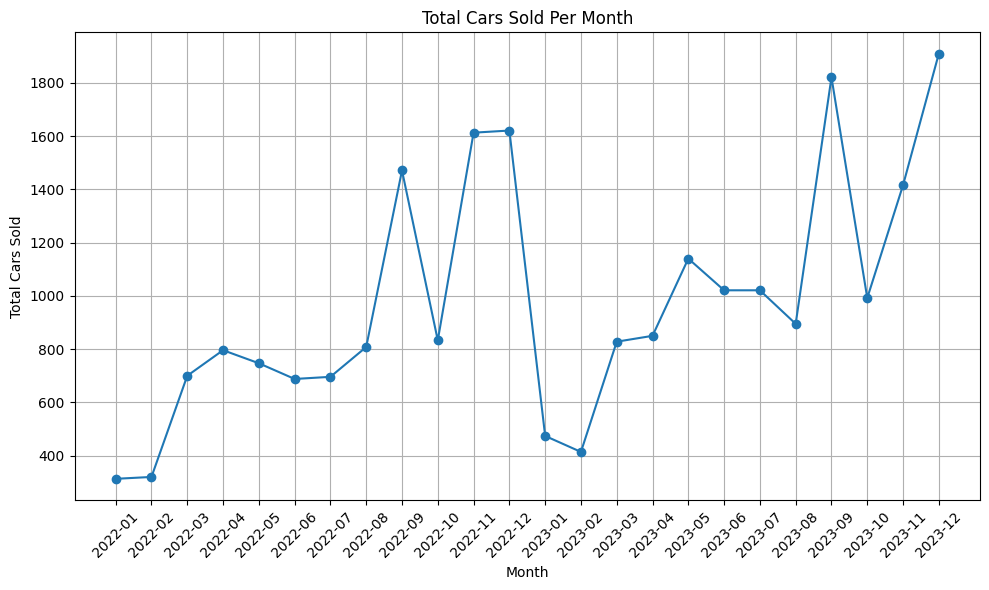

In [0]:
# Extract month from date and aggregate total cars sold
golden_pandas_df["month"] = pd.to_datetime(golden_pandas_df["date"]).dt.to_period("M")

# Aggregate total cars sold per month
cars_sold_per_month = golden_pandas_df.groupby("month").size().reset_index(name="count")

# Sort values for better visualization
cars_sold_per_month = cars_sold_per_month.sort_values("month")

# Plotting
plt.figure(figsize=(10, 6))
plt.plot(cars_sold_per_month["month"].astype(str), cars_sold_per_month["count"], marker='o', linestyle='-')
plt.title("Total Cars Sold Per Month")
plt.xlabel("Month")
plt.ylabel("Total Cars Sold")
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

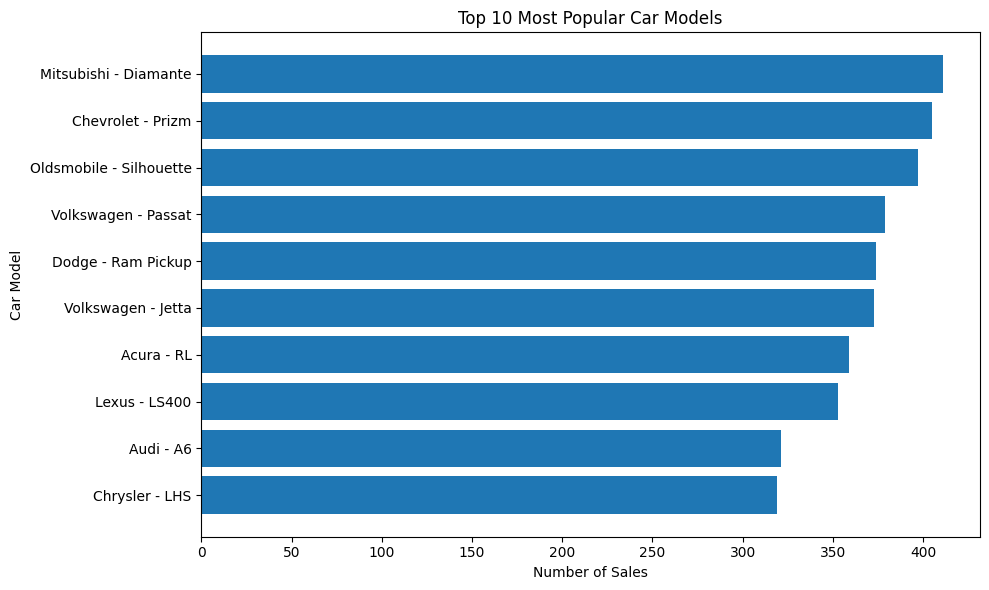

In [0]:
# Combine company_name and model for better clarity
golden_pandas_df["car_full_name"] = golden_pandas_df["company_name"] + " - " + golden_pandas_df["model"]

# Aggregate sales count by car_full_name
popular_car_models = golden_pandas_df["car_full_name"].value_counts().reset_index()
popular_car_models.columns = ["car_full_name", "count"]

# Select top 10 most popular car models
popular_car_models = popular_car_models.head(10)

# Plotting
plt.figure(figsize=(10, 6))
plt.barh(popular_car_models["car_full_name"], popular_car_models["count"])
plt.title("Top 10 Most Popular Car Models")
plt.xlabel("Number of Sales")
plt.ylabel("Car Model")
plt.gca().invert_yaxis()  # Invert for better readability
plt.tight_layout()
plt.show()
golden_pandas_df = golden_pandas_df.drop("car_full_name", axis=1)


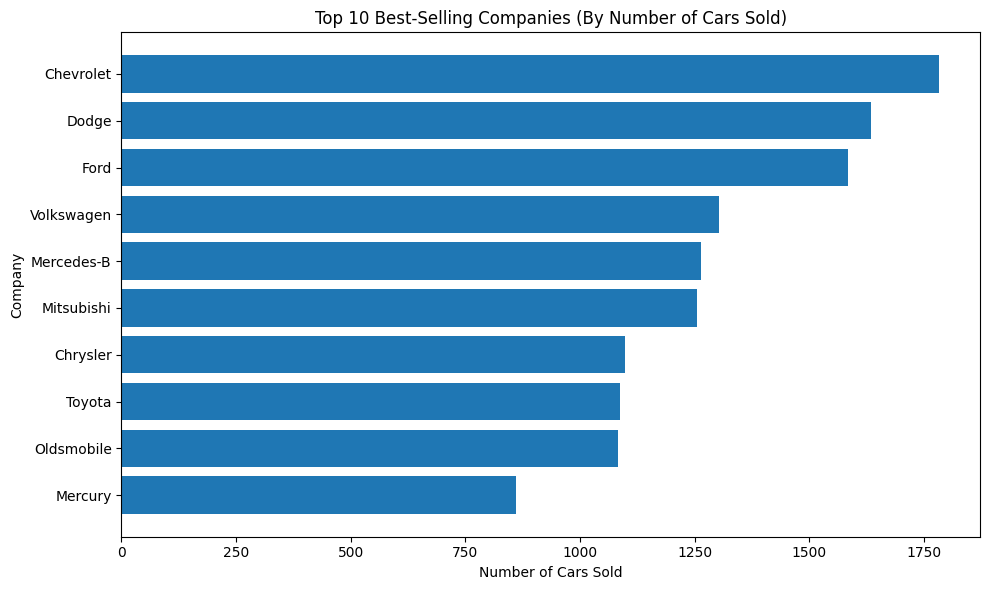

In [0]:
# Aggregate total cars sold by company
best_selling_companies_sold = golden_pandas_df["company_name"].value_counts().reset_index()
best_selling_companies_sold.columns = ["company_name", "count"]

# Select top 10 best-selling companies
best_selling_companies_sold = best_selling_companies_sold.head(10)

# Plotting
plt.figure(figsize=(10, 6))
plt.barh(best_selling_companies_sold["company_name"], best_selling_companies_sold["count"])
plt.title("Top 10 Best-Selling Companies (By Number of Cars Sold)")
plt.xlabel("Number of Cars Sold")
plt.ylabel("Company")
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()


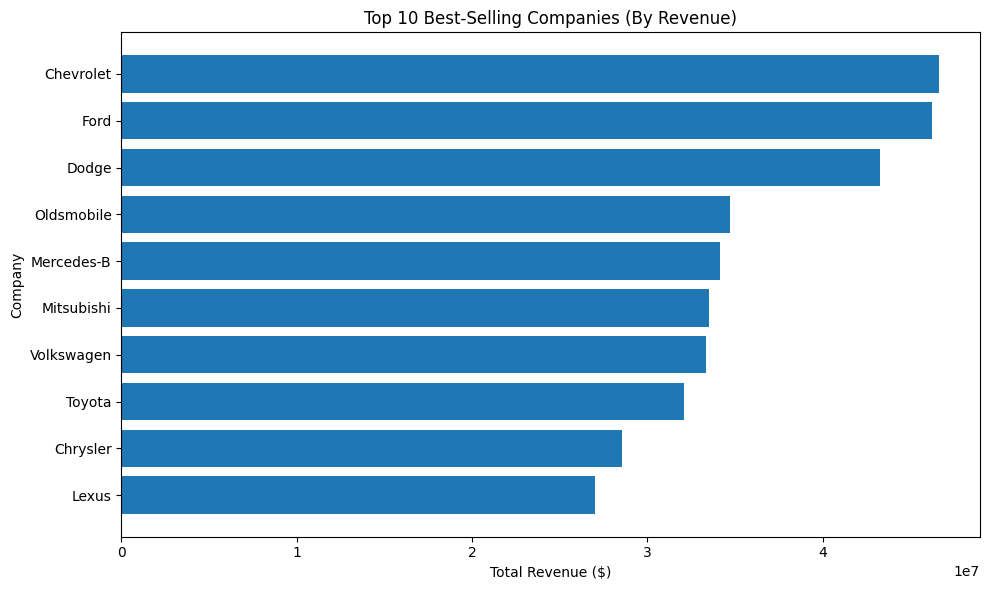

In [0]:
# Aggregate total revenue by company
best_selling_companies_revenue = golden_pandas_df.groupby("company_name")["price_$"].sum().reset_index()

# Sort values by total revenue (descending order)
best_selling_companies_revenue = best_selling_companies_revenue.sort_values("price_$", ascending=False).head(10)

# Plotting
plt.figure(figsize=(10, 6))
plt.barh(best_selling_companies_revenue["company_name"], best_selling_companies_revenue["price_$"])
plt.title("Top 10 Best-Selling Companies (By Revenue)")
plt.xlabel("Total Revenue ($)")
plt.ylabel("Company")
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()


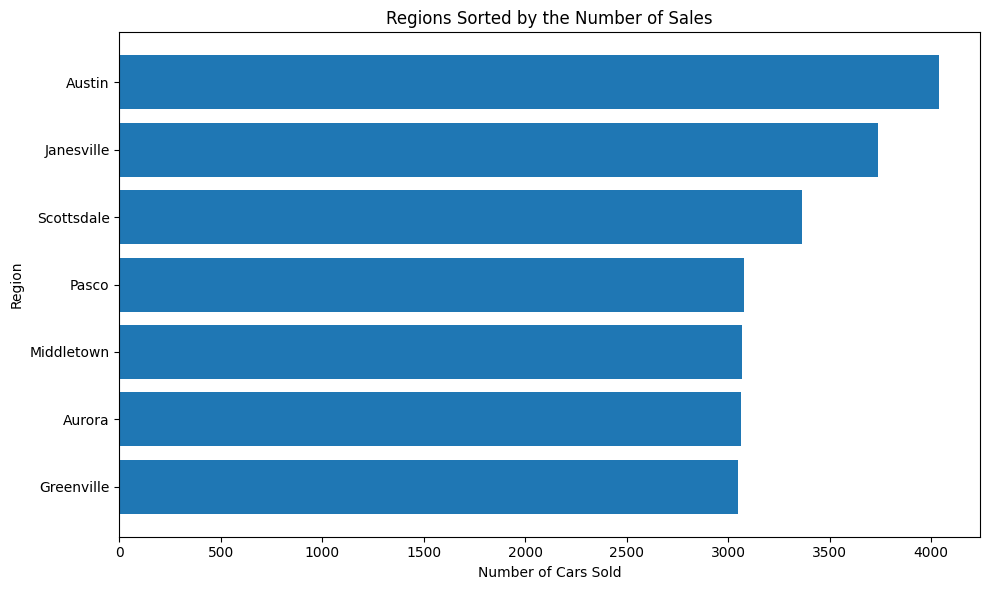

In [0]:
# Aggregate total cars sold by region
top_regions = golden_pandas_df["dealer_region"].value_counts().reset_index()
top_regions.columns = ["dealer_region", "count"]



# Plotting
plt.figure(figsize=(10, 6))
plt.barh(top_regions["dealer_region"], top_regions["count"])
plt.title("Regions Sorted by the Number of Sales")
plt.xlabel("Number of Cars Sold")
plt.ylabel("Region")
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()

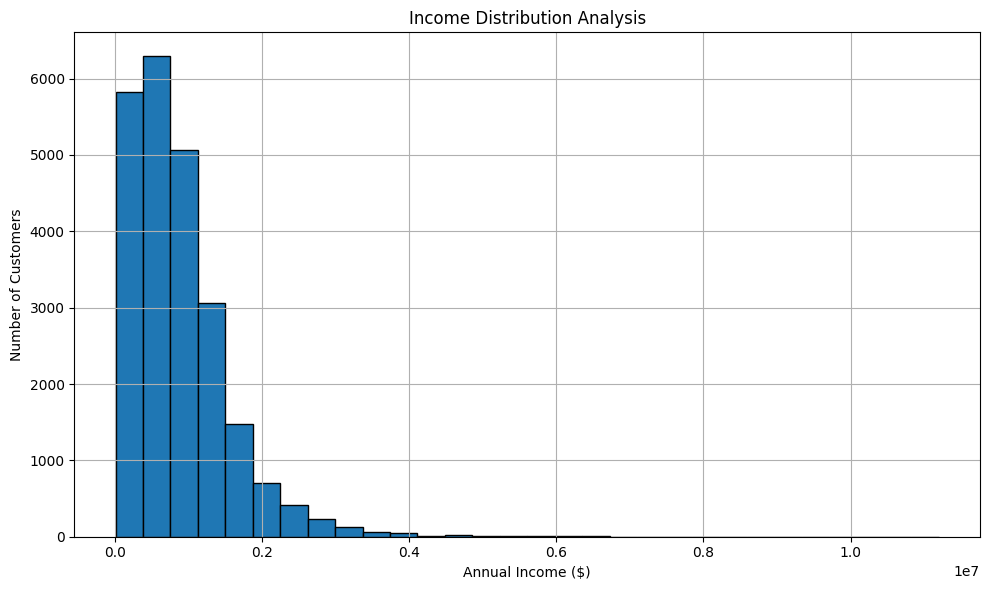

In [0]:
# Plotting
plt.figure(figsize=(10, 6))
plt.hist(golden_pandas_df["annual_income_$"], bins=30, edgecolor='black')
plt.title("Income Distribution Analysis")
plt.xlabel("Annual Income ($)")
plt.ylabel("Number of Customers")

plt.grid(True)
plt.tight_layout()
plt.show()

<Axes: xlabel='price_$', ylabel='Count'>

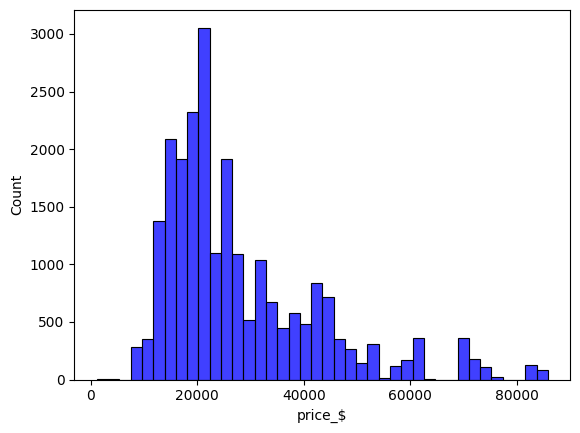

In [0]:
plt.ticklabel_format(style='plain', axis='x')
sns.histplot(data=golden_pandas_df, x='price_$',stat='count',bins=40,color='blue')

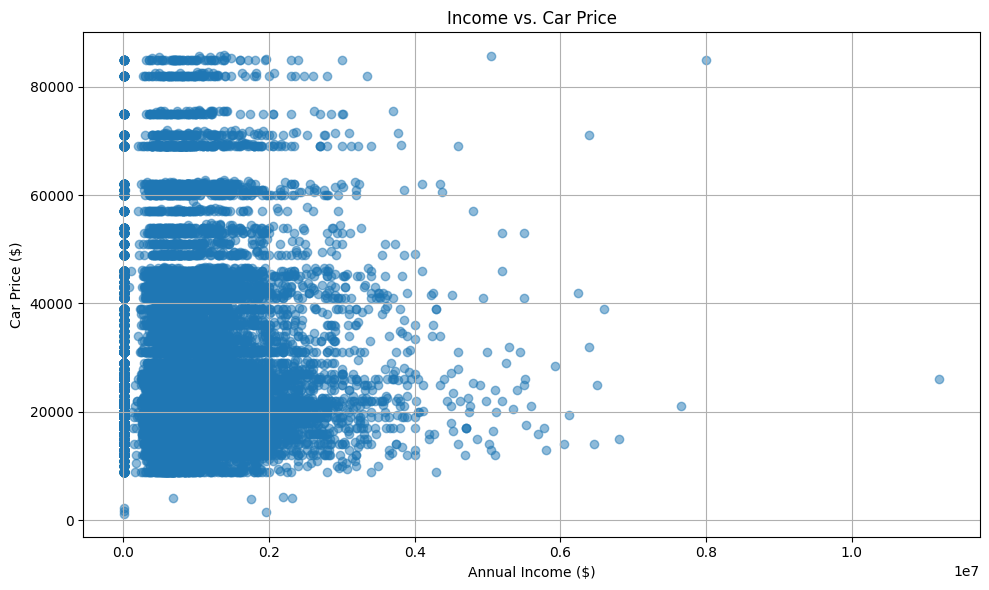

In [0]:
# Plotting
plt.figure(figsize=(10, 6))
plt.scatter(golden_pandas_df["annual_income_$"], golden_pandas_df["price_$"], alpha=0.5)
plt.title("Income vs. Car Price")
plt.xlabel("Annual Income ($)")
plt.ylabel("Car Price ($)")
plt.grid(True)
plt.tight_layout()
plt.show()

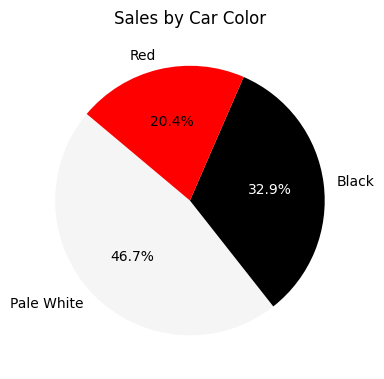

In [0]:
# Aggregate total cars sold by car color
sales_by_color = golden_pandas_df["color"].value_counts().reset_index()
sales_by_color.columns = ["color", "count"]

# Define color mapping for the pie chart
color_mapping = {
    "Pale White": "#f5f5f5",
    "Black": "#000000",
    "Red": "#FF0000"
}

# Extract matching colors for the pie chart
colors = [color_mapping.get(color, "#808080") for color in sales_by_color["color"]]

# Plotting
plt.figure(figsize=(4, 4))
wedges, texts, autotexts = plt.pie(
    sales_by_color["count"], 
    labels=sales_by_color["color"], 
    colors=colors, 
    autopct='%.1f%%',
    startangle=140
)

# Change the text color for better visibility
for text, autotext in zip(texts, autotexts):
    if text.get_text() == "Black":
        autotext.set_color("white")  # White text on black section

plt.title("Sales by Car Color")
plt.tight_layout()
plt.show()


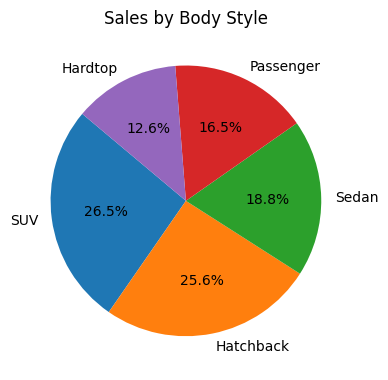

In [0]:
# Aggregate total cars sold by body style
sales_by_body_style = golden_pandas_df["body_style"].value_counts().reset_index()
sales_by_body_style.columns = ["body_style", "count"]

# Plotting
plt.figure(figsize=(4, 4))
plt.pie(
    sales_by_body_style["count"], 
    labels=sales_by_body_style["body_style"], 
    autopct='%.1f%%',
    startangle=140
)
plt.title("Sales by Body Style")
plt.tight_layout()
plt.show()

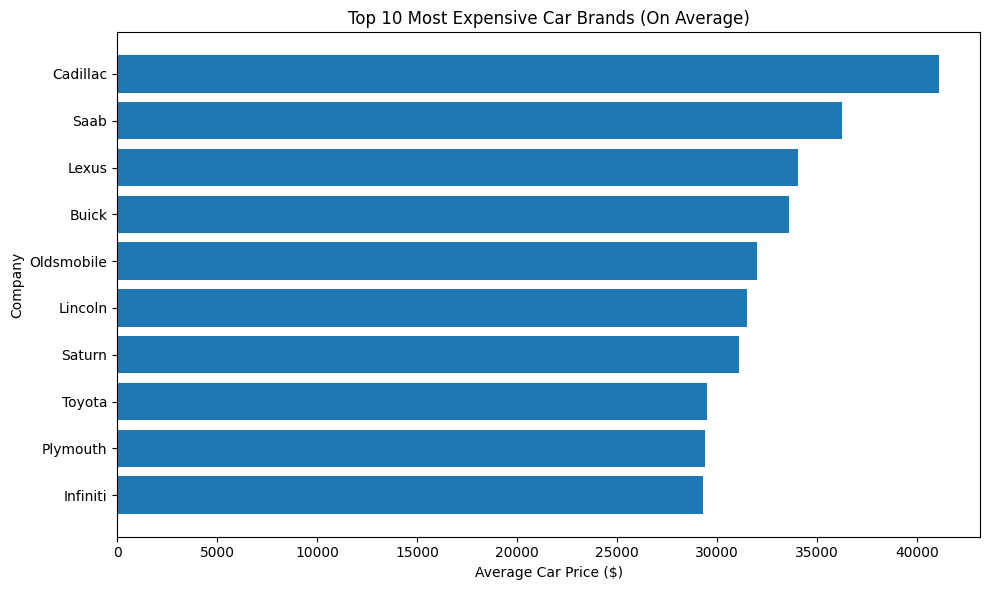

In [0]:
# Calculate average car price by company
avg_price_by_company = golden_pandas_df.groupby("company_name")["price_$"].mean().reset_index()

# Sort values by average price (descending order)
avg_price_by_company = avg_price_by_company.sort_values("price_$", ascending=False).head(10)

# Plotting
plt.figure(figsize=(10, 6))
plt.barh(avg_price_by_company["company_name"], avg_price_by_company["price_$"])
plt.title("Top 10 Most Expensive Car Brands (On Average)")
plt.xlabel("Average Car Price ($)")
plt.ylabel("Company")
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()

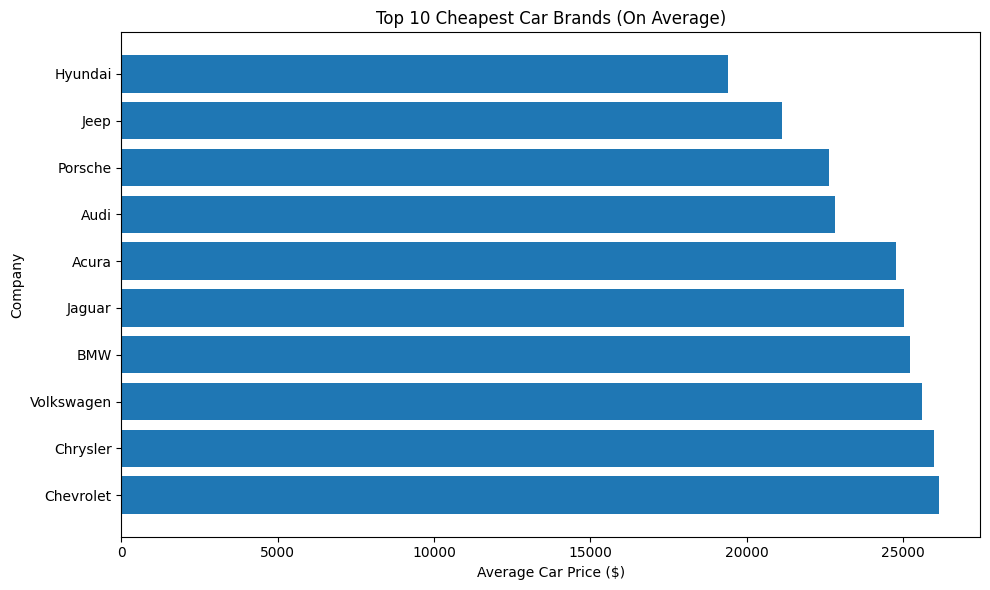

In [0]:
# Calculate average car price by company
avg_price_by_company = golden_pandas_df.groupby("company_name")["price_$"].mean().reset_index()

# Sort values by average price (ascending order)
avg_price_by_company = avg_price_by_company.sort_values("price_$", ascending=True).head(10)

# Plotting
plt.figure(figsize=(10, 6))
plt.barh(avg_price_by_company["company_name"], avg_price_by_company["price_$"])
plt.title("Top 10 Cheapest Car Brands (On Average)")
plt.xlabel("Average Car Price ($)")
plt.ylabel("Company")
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()

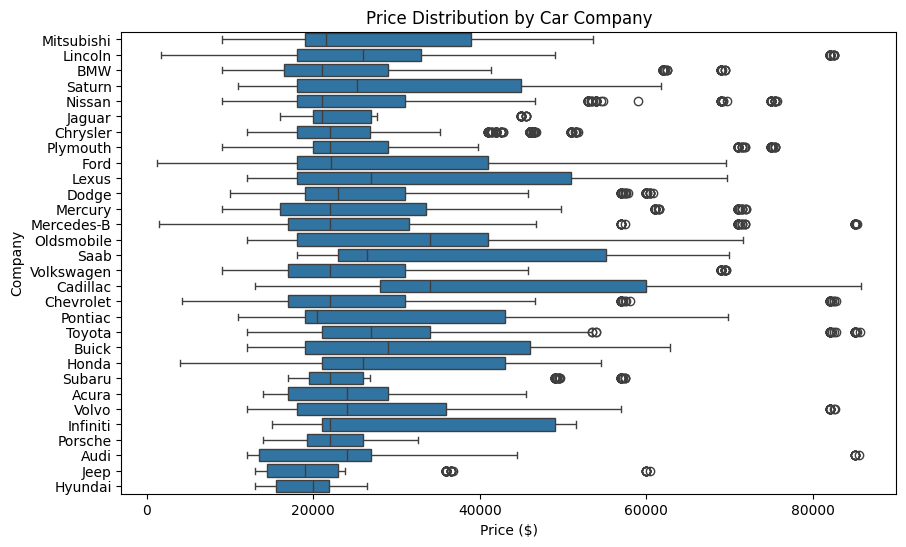

In [0]:
plt.figure(figsize=(10, 6))
sns.boxplot(x='price_$', y='company_name', data=golden_pandas_df)
plt.title('Price Distribution by Car Company')
plt.xlabel('Price ($)')
plt.ylabel('Company')
plt.show()

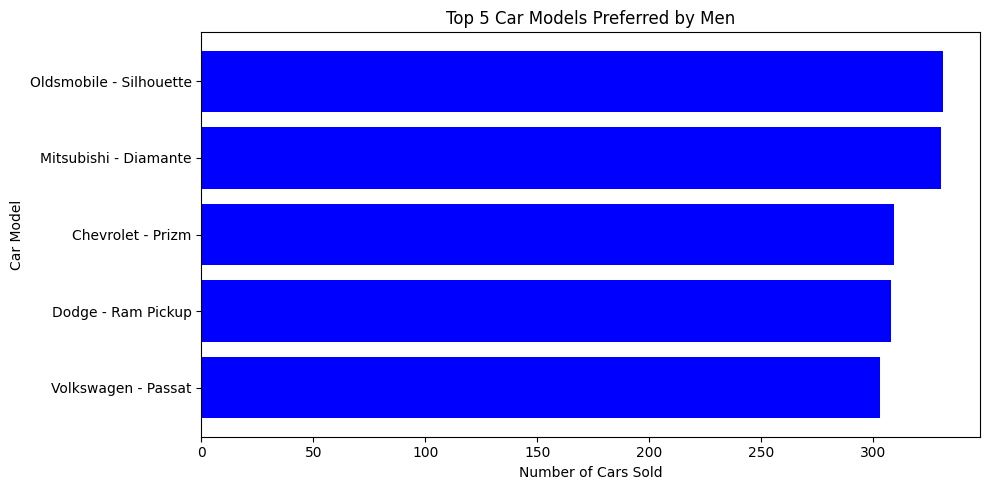

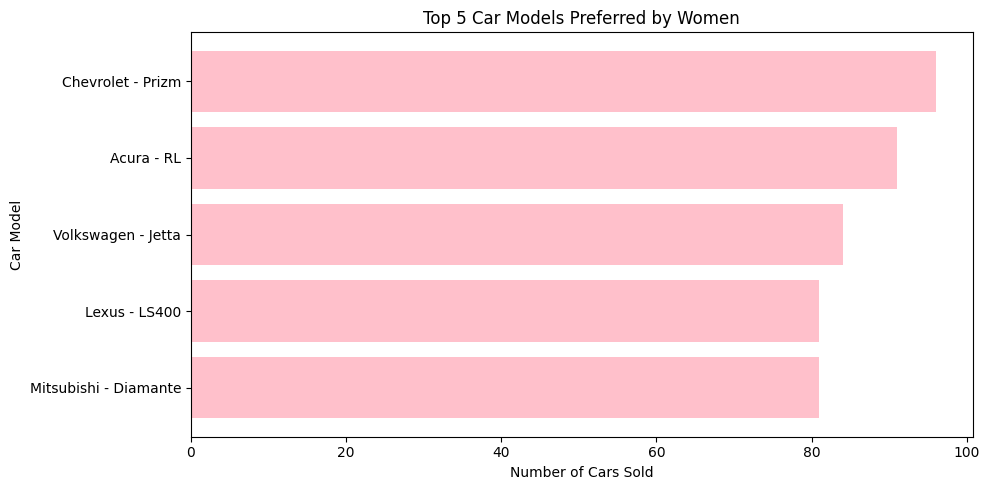

In [0]:
# Create a temporary column for plotting
golden_pandas_df['temp_car_full_name'] = golden_pandas_df['company_name'] + " - " + golden_pandas_df['model']

# Aggregate data by the temporary column and gender
top_sold_by_gender = golden_pandas_df.groupby(['temp_car_full_name', 'gender']).size().reset_index(name='count')

# Separate data for men and women
top_men_models = top_sold_by_gender[top_sold_by_gender['gender'] == 'Male'].nlargest(5, 'count')
top_women_models = top_sold_by_gender[top_sold_by_gender['gender'] == 'Female'].nlargest(5, 'count')

# Plotting for Men (Blue Bars - Left Side)
plt.figure(figsize=(10, 5))
plt.barh(top_men_models['temp_car_full_name'], top_men_models['count'], color='blue', label='Men')
plt.title('Top 5 Car Models Preferred by Men')
plt.xlabel('Number of Cars Sold')
plt.ylabel('Car Model')
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()

# Plotting for Women (Pink Bars - Right Side)
plt.figure(figsize=(10, 5))
plt.barh(top_women_models['temp_car_full_name'], top_women_models['count'], color='pink', label='Women')
plt.title('Top 5 Car Models Preferred by Women')
plt.xlabel('Number of Cars Sold')
plt.ylabel('Car Model')
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()

# Remove the temporary column
golden_pandas_df.drop('temp_car_full_name', axis=1, inplace=True)
